In [183]:
import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import clear_output

In [184]:
# Training Data
x_train = pd.read_csv("titanic_data/train.csv",
                 na_values=['', '?', '-'],skip_blank_lines=False)
# Testing Data
test = pd.read_csv("titanic_data/test.csv",
                 na_values=['', '?', '-'],skip_blank_lines=False)
y_test = pd.read_csv("titanic_data/gender_submission.csv",
                 na_values=['', '?', '-'], skip_blank_lines=False)

x_test = pd.concat([test,y_test]) # Concatinating two dataframes

x_train.shape , x_test.shape,x_train.head()

((891, 12),
 (836, 12),
    PassengerId  Survived  Pclass  \
 0            1         0       3   
 1            2         1       1   
 2            3         1       3   
 3            4         1       1   
 4            5         0       3   
 
                                                 Name     Sex   Age  SibSp  \
 0                            Braund, Mr. Owen Harris    male  22.0      1   
 1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                             Heikkinen, Miss. Laina  female  26.0      0   
 3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                           Allen, Mr. William Henry    male  35.0      0   
 
    Parch            Ticket     Fare Cabin Embarked  
 0      0         A/5 21171   7.2500   NaN        S  
 1      0          PC 17599  71.2833   C85        C  
 2      0  STON/O2. 3101282   7.9250   NaN        S  
 3      0            113803  53.1000  C123        S  
 4      0   

###  CLearning and filling data


In [185]:
# Training data
x_train = x_train.fillna(method='ffill')
x_train = x_train.fillna(method='bfill')
x_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [186]:
# Testing Data
x_test = x_test.fillna(method='bfill')
x_test = x_test.fillna(method='ffill')
x_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Survived       0
dtype: int64

### **Survival rate on Titanic**

In [187]:
# Males
train_males = x_train.loc[x_train.Sex == 'male']["Survived"]
test_males = x_test.loc[x_train.Sex=='male']['Survived']

train_prob = sum(train_males)/len(train_males)
test_prob= sum(test_males)/len(test_males)
print("Survival Rate of males on Train data : ",train_prob)
print("Survival Rate of males on Test data : ",test_prob)

Survival Rate of males on Train data :  0.18890814558058924
Survival Rate of males on Test data :  0.1821705426356589


In [188]:
# females
train_females = x_train.loc[x_train.Sex == 'female']["Survived"]
test_females = x_test.loc[x_train.Sex=='female']['Survived']

train_prob = sum(train_females)/len(train_females)
test_prob= sum(test_females)/len(test_females)
print("Survival Rate of females on Train data : ",train_prob)
print("Survival Rate of females on Test data : ",test_prob)
test_females

Survival Rate of females on Train data :  0.7420382165605095
Survival Rate of females on Test data :  0.18125


1      0.0
2      0.0
3      0.0
8      0.0
9      0.0
      ... 
409    1.0
412    1.0
415    0.0
416    0.0
417    0.0
Name: Survived, Length: 320, dtype: float64

In [192]:
y_train = x_train.pop('Survived')
y_test = x_test.pop('Survived')
y_train.shape , y_test.shape ,x_train.shape, x_test.shape

((891,), (836,), (891, 11), (836, 11))

In [193]:
CATEGORICAL_COLUMN = ["Name" , "Sex" , "Ticket","Cabin","Embarked"]
NUMERICAL_COLUMN = ["PassengerId" , "Pclass","Age","SibSp","Parch", "Fare"]
features_column = []

for feature_name in CATEGORICAL_COLUMN :
    vocab = x_train[feature_name].unique()
    features_column.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocab))

for feature_name in NUMERICAL_COLUMN :
    features_column.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
s = pd.DataFrame(features_column)
s.head()

,key,vocabulary_list,dtype,default_value,num_oov_buckets
0,Name,"(Braund, Mr. Owen Harris, Cumings, Mrs. John B...",<dtype: 'string'>,-1,0.0
1,Sex,"(male, female)",<dtype: 'string'>,-1,0.0
2,Ticket,"(A/5 21171, PC 17599, STON/O2. 3101282, 113803...",<dtype: 'string'>,-1,0.0
3,Cabin,"(C85, C123, E46, G6, C103, D56, A6, C23 C25 C2...",<dtype: 'string'>,-1,0.0
4,Embarked,"(S, C, Q)",<dtype: 'string'>,-1,0.0


In [194]:
# Input Function
def make_input_fn(data_df , label_df , num_epochs=10, shuffle=True , batch_size=32):
    def input_function(): #inner function, this will be returned
        # Create tf.data.Dataset object with data and its label
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle :
            ds = ds.shuffle(1000) #random order of data
        ds = ds.batch(batch_size).repeat(num_epochs)#split dataset into batches of 32 and repeat process for number of epochs
        return ds # return a batch of dataset
    return input_function # return a function object for use

# here we will call the input function that was return to
train_eval = make_input_fn(x_train , y_train,50) 
test_eval = make_input_fn(x_test , y_test , num_epochs=1 , shuffle=False)

In [195]:
# Creating Model

# we are creating linear estimator by passing feature_columns we created earlier. 
linear_est = tf.estimator.LinearClassifier(feature_columns=features_column)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\india\\AppData\\Local\\Temp\\tmpori2_akz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [200]:
# Training
linear_est.train(train_eval) #train


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\india\AppData\Local\Temp\tmpori2_akz\model.ckpt-2800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2800...
INFO:tensorflow:Saving checkpoints for 2800 into C:\Users\india\AppData\Local\Temp\tmpori2_akz\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2800...
INFO:tensorflow:loss = 0.11725638, step = 2800
INFO:tensorflow:global_step/sec: 151.346
INFO:tensorflow:loss = 0.16228506, step = 2900 (0.661 sec)
INFO:tensorflow:global_step/sec: 401.844
INFO:tensorflow:loss = 0.09470825, step = 3000 (0.249 sec)
INFO:tensorflow:global_step/sec: 396.081
INFO:tensorflow:loss = 0.13054581, step = 3100 (0.256 sec)
INFO:tensorflow:global_step/sec: 399.839
INFO:tens

In [201]:
# Testing Model
result = linear_est.evaluate(test_eval) # get model metrics/stats by testing on testing data

clear_output() # it clears the console output
print(result['accuracy']) # the result varaible is simply a dict of stats about our model

0.6447368


In [202]:
result = pd.DataFrame(result, index=[i for i in range(1,len(result)+1)])
result.head()

,accuracy,accuracy_baseline,auc,auc_precision_recall,average_loss,label/mean,loss,precision,prediction/mean,recall,global_step
1,0.644737,0.818182,0.472948,0.157187,0.842885,0.181818,0.837177,0.0,0.220219,0.0,4200
2,0.644737,0.818182,0.472948,0.157187,0.842885,0.181818,0.837177,0.0,0.220219,0.0,4200
3,0.644737,0.818182,0.472948,0.157187,0.842885,0.181818,0.837177,0.0,0.220219,0.0,4200
4,0.644737,0.818182,0.472948,0.157187,0.842885,0.181818,0.837177,0.0,0.220219,0.0,4200
5,0.644737,0.818182,0.472948,0.157187,0.842885,0.181818,0.837177,0.0,0.220219,0.0,4200


In [204]:
# Predicting from our model
predicted = list(linear_est.predict(test_eval))

INFO:tensorflow:Calling model_fn.


c:\users\india\appdata\local\programs\python\python38\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\india\AppData\Local\Temp\tmpori2_akz\model.ckpt-4200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [212]:
print("Chances of Surviving : ",predicted[1]['probabilities'][1])
print("Chances of not Surviving : ",predicted[1]['probabilities'][0])
print(x_test.loc[1])

Chances of Surviving :  0.4112583
Chances of not Surviving :  0.5887418
   PassengerId  Pclass                              Name     Sex   Age  SibSp  \
1          893     3.0  Wilkes, Mrs. James (Ellen Needs)  female  47.0    1.0   
1          893     3.0          Peter, Master. Michael J    male  38.5    1.0   

   Parch  Ticket     Fare Cabin Embarked  
1    0.0  363272   7.0000   B45        S  
1    1.0    2668  22.3583  C105        C  


In [232]:
r = pd.DataFrame(predicted)
p = r.loc[:]['probabilities']
survived = []
not_survived = []
for i,j in p :
    not_survived.append(i)
    survived.append(j)
data = {
    "survived" : survived,
    "not_survived" : not_survived
}

data = pd.DataFrame(data)
data.loc[:][400:500]

,survived,not_survived
400,0.982868,0.017132
401,0.035270,0.964730
402,0.957997,0.042003
403,0.120968,0.879032
404,0.146989,0.853011
...,...,...
495,0.099881,0.900119
496,0.099860,0.900140
497,0.099839,0.900161
498,0.099819,0.900181


In [230]:
x_test.loc[:][400:500]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
400,1292,1.0,"Bonnell, Miss. Caroline",female,30.0,0.0,0.0,36928,164.8667,C7,S
401,1293,2.0,"Gale, Mr. Harry",male,38.0,1.0,0.0,28664,21.0000,D40,S
402,1294,1.0,"Gibson, Miss. Dorothy Winifred",female,22.0,0.0,1.0,112378,59.4000,D40,C
403,1295,1.0,"Carrau, Mr. Jose Pedro",male,17.0,0.0,0.0,113059,47.1000,D40,S
404,1296,1.0,"Frauenthal, Mr. Isaac Gerald",male,43.0,1.0,0.0,17765,27.7208,D40,C
...,...,...,...,...,...,...,...,...,...,...,...
77,969,3.0,"Peter, Master. Michael J",male,38.5,1.0,1.0,2668,22.3583,C105,C
78,970,3.0,"Peter, Master. Michael J",male,38.5,1.0,1.0,2668,22.3583,C105,C
79,971,3.0,"Peter, Master. Michael J",male,38.5,1.0,1.0,2668,22.3583,C105,C
80,972,3.0,"Peter, Master. Michael J",male,38.5,1.0,1.0,2668,22.3583,C105,C


In [253]:
data['Sex'] = x_train['Sex']
data

,survived,not_survived,Sex
0,0.033049,0.966951,male
1,0.411258,0.588742,female
2,0.042758,0.957242,female
3,0.037524,0.962476,female
4,0.677649,0.322351,male
...,...,...,...
831,0.093141,0.906859,male
832,0.093122,0.906878,male
833,0.093102,0.906898,male
834,0.093083,0.906917,male


Text(0.5, 0, 'Unknown')

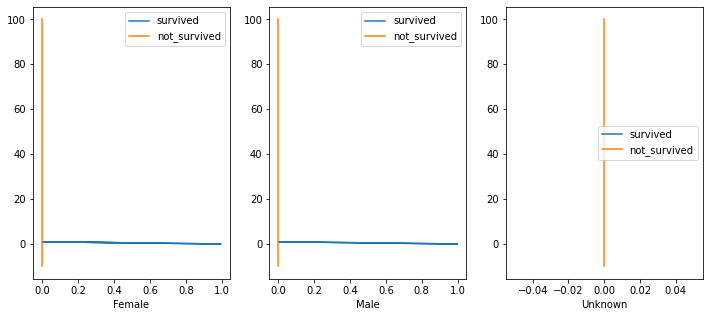

In [274]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(data.loc[data.Sex=='female']['survived'],data.loc[data.Sex=='female']['not_survived'])
plt.plot([0,0,0],[-10,0,100])
plt.legend(['survived','not_survived'])
plt.xlabel("Female")

plt.subplot(1,3,2)
plt.plot(data.loc[data.Sex=='male']['survived'],data.loc[data.Sex=='male']['not_survived'])
plt.plot([0,0,0],[-10,0,100])
plt.legend(['survived','not_survived'])
plt.xlabel("Male")

plt.subplot(1,3,3)
plt.plot(data.loc[data.Sex=='NaN']['survived'],data.loc[data.Sex=='NaN']['not_survived'])
plt.plot([0,0,0],[-10,0,100])
plt.legend(['survived','not_survived'])
plt.xlabel("Unknown")
